# Práctica 3 - Octava prueba

#### Pilar Navarro Ramírez

In [1]:
import pandas as pd

## Preprocesamiento

In [2]:
df_train=pd.read_csv("data/train.csv",na_values=[""])
df_test=pd.read_csv("data/test.csv",na_values=[""])

In [3]:
df_train.columns = [col.lower() for col in df_train]
df_test.columns = [col.lower() for col in df_test]

df_train_orig = df_train.copy()
df_test_orig = df_test.copy()

del df_train["id"]
del df_test["id"]

### Tratamos los datos perdidos

In [4]:
from sklearn import impute

In [5]:
del df_train['descuento']
del df_test['descuento']

In [6]:
df_train_replaced=df_train.copy()
imputer=impute.SimpleImputer(strategy="most_frequent")
values = imputer.fit_transform([df_train_replaced.asientos.values])
df_train_replaced.asientos.update(pd.Series(values[0]))

In [7]:
df_train_replaced=df_train_replaced.dropna()
df_train=df_train.dropna()

Separamos el atributo a predecir del resto de atributos en el conjunto de entrenamiento.

In [8]:
cols = [col for col in df_train.columns if col not in ['precio_cat']]    
df_train, df_train_obj= df_train[cols], df_train['precio_cat']
df_train_replaced, df_train_obj_replaced= df_train_replaced[cols], df_train_replaced['precio_cat']

### Normalización de los datos numéricos

In [9]:
from sklearn.preprocessing import MinMaxScaler

exc=["nombre","ciudad","combustible","tipo_marchas","mano","consumo","motor_cc","potencia",'precio_cat','id','descuento']
cols = [col for col in df_train_orig.columns if col not in exc]  


df_train_norm=df_train.copy()
df_train_norm_rpl=df_train_replaced.copy()
df_test_norm=df_test.copy()


for atributo in cols:
    data=pd.read_csv("data/"+atributo+".csv")
    data.columns = [col.lower() for col in data]
    scaler = MinMaxScaler().fit(data.values)
    train_values=df_train[atributo].values.reshape(-1,1)
    df_train_norm[atributo]=scaler.transform(train_values)
    train_values_rpl=df_train_replaced[atributo].values.reshape(-1,1)
    df_train_norm_rpl[atributo]=scaler.transform(train_values_rpl)
    test_values=df_test[atributo].values.reshape(-1,1)
    df_test_norm[atributo]=scaler.transform(test_values)
    

### 'Transformación' de variables categóricas a binarias

In [10]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

categorical=["nombre","ciudad","combustible","tipo_marchas","mano","consumo","motor_cc","potencia"]
cols = [col for col in df_train.columns if col not in categorical]    

df_train_num=df_train_norm.copy()
df_train_num_rpl=df_train_norm_rpl.copy()
df_test_num=df_test_norm.copy()

df_train_num=np.array(df_train_num[cols])
df_train_num_rpl=np.array(df_train_num_rpl[cols])
df_test_num=np.array(df_test_num[cols])

for atributo in categorical:
    data=pd.read_csv("data/"+atributo+".csv")
    data.columns = [col.lower() for col in data]
    enc = OneHotEncoder().fit(data[atributo].values.reshape(-1,1))

    #Conjunto de entrenamiento con ambos preprocesamientos
    enc_train=enc.transform(df_train[atributo].values.reshape(-1,1)).toarray()        
    df_train_num=np.hstack((df_train_num,enc_train))
    
    enc_train_rpl=enc.transform(df_train_replaced[atributo].values.reshape(-1,1)).toarray()
    df_train_num_rpl=np.hstack((df_train_num_rpl,enc_train_rpl))

    
    #Conjunto de test
    enc_test=enc.transform(df_test[atributo].values.reshape(-1,1)).toarray()
    df_test_num=np.hstack((df_test_num,enc_test))
                          
df_train_num=pd.DataFrame(df_train_num)
df_train_num_rpl=pd.DataFrame(df_train_num_rpl)
df_test_num=pd.DataFrame(df_test_num)

Eliminamos las columnas que son todo nula.

In [11]:
cols = [col for col in df_train_num.columns if df_train_num[col].max()!=0.0]
df_train_num=df_train_num[cols]
df_test_num=df_test_num[cols]
df_train_num_rpl=df_train_num_rpl[cols]

### Oversampling

In [12]:
from imblearn.over_sampling import SMOTE
from collections import Counter
smote=SMOTE(random_state=10)
df_train_over, df_train_obj_over = smote.fit_resample(df_train_num, df_train_obj)
df_train_over_rpl, df_train_obj_over_rpl = smote.fit_resample(df_train_num_rpl, df_train_obj_replaced)
Counter(df_train_obj_over)

Counter({3: 1825, 2: 1825, 4: 1825, 5: 1825, 1: 1825})

## Aplicación de los algoritmos

In [13]:
import numpy as np

from sklearn.model_selection import cross_val_score

def cross_validation(clf,x,y,mostrar=False):
    scores=cross_val_score(clf,x,y,scoring='accuracy',cv=5)
    accuracy=np.mean(scores)  
    if mostrar:
        print("Accuracy: ", accuracy)
    return accuracy

In [30]:
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier


extra=ExtraTreesClassifier(random_state=10)
gradient=GradientBoostingClassifier(random_state=10,max_features='auto')
svc=LinearSVC(random_state=10)
knn=KNeighborsClassifier()
tree=DecisionTreeClassifier(random_state=10)
forest=RandomForestClassifier(random_state=10)
NN=MLPClassifier(random_state=10,max_iter=10000)

clfs=[svc,knn,tree,forest,NN,extra,gradient]
for clf in clfs:
    print(clf)
    cross_validation(clf, df_train_over, df_train_obj_over,True)

LinearSVC(random_state=10)
Accuracy:  0.8900821917808219
KNeighborsClassifier()
Accuracy:  0.8642191780821917
DecisionTreeClassifier(random_state=10)
Accuracy:  0.8896438356164383
RandomForestClassifier(random_state=10)
Accuracy:  0.9376438356164384
MLPClassifier(max_iter=10000, random_state=10)
Accuracy:  0.9375342465753425
ExtraTreesClassifier(random_state=10)
Accuracy:  0.940931506849315
GradientBoostingClassifier(max_features='auto', random_state=10)
Accuracy:  0.8585205479452055


### Configuración de los parámetros

#### Extra Trees

Parámetro bootstrap.

In [31]:
extra=ExtraTreesClassifier(random_state=10,bootstrap=True)
cross_validation(extra, df_train_over, df_train_obj_over,True)

Accuracy:  0.9377534246575342


0.9377534246575342

In [32]:
extra=ExtraTreesClassifier(random_state=10)
cross_validation(extra, df_train_over, df_train_obj_over,True)

Accuracy:  0.940931506849315


0.940931506849315

Configuramos el número de árboles

In [33]:
from matplotlib import pyplot as plt

def tune_num_arboles(max_value):
    acc=[]
    for i in range(5,max_value,20):
        extra=ExtraTreesClassifier(n_estimators=i,random_state=10)
        acc.append(cross_validation(extra,df_train_over,df_train_obj_over))

    fig, ax =plt.subplots(figsize=(15,5))
    ax.plot(range(5,max_value,20), acc)
    ax.set_title('Extra trees')
    ax.set_xlabel('Num árboles')
    ax.set_ylabel('Accuracy')
    plt.show()

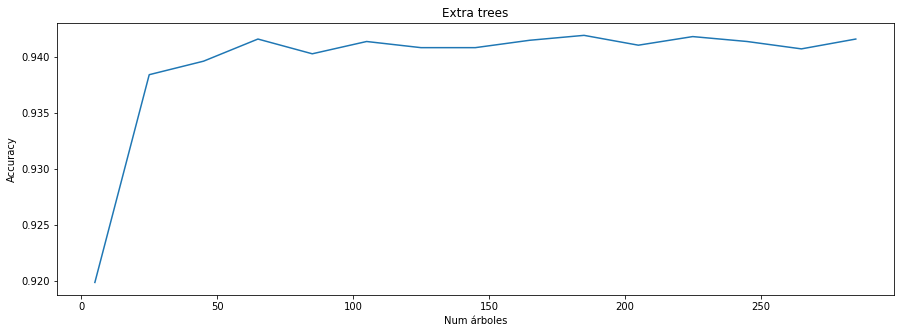

In [34]:
tune_num_arboles(300)

In [35]:
extra=ExtraTreesClassifier(n_estimators=150,random_state=10)
cross_validation(extra, df_train_over, df_train_obj_over,True)

Accuracy:  0.9414794520547944


0.9414794520547944

In [36]:
extra=ExtraTreesClassifier(n_estimators=275,random_state=10)
cross_validation(extra, df_train_over, df_train_obj_over,True)

Accuracy:  0.9410410958904109


0.9410410958904109

In [37]:
extra=ExtraTreesClassifier(n_estimators=250,random_state=10)
cross_validation(extra, df_train_over, df_train_obj_over,True)

Accuracy:  0.9408219178082191


0.9408219178082191

In [38]:
extra=ExtraTreesClassifier(n_estimators=240,random_state=10)
cross_validation(extra, df_train_over, df_train_obj_over,True)

Accuracy:  0.9413698630136986


0.9413698630136986

In [39]:
extra=ExtraTreesClassifier(n_estimators=350,random_state=10)
cross_validation(extra, df_train_over, df_train_obj_over,True)

Accuracy:  0.9415890410958904


0.9415890410958904

Vemos si mejora al cambiar el parámetro max_depth:

In [40]:
extra=ExtraTreesClassifier(n_estimators=275,random_state=10,max_depth=60)
cross_validation(extra, df_train_over, df_train_obj_over,True)

Accuracy:  0.9385205479452056


0.9385205479452056

In [41]:
extra=ExtraTreesClassifier(n_estimators=275,random_state=10,max_depth=50)
cross_validation(extra, df_train_over, df_train_obj_over,True)

Accuracy:  0.9330410958904108


0.9330410958904108

In [42]:
extra=ExtraTreesClassifier(n_estimators=275,random_state=10,max_depth=20)
cross_validation(extra, df_train_over, df_train_obj_over,True)

Accuracy:  0.8587397260273972


0.8587397260273972

In [43]:
extra=ExtraTreesClassifier(n_estimators=275,random_state=10,max_depth=80)
cross_validation(extra, df_train_over, df_train_obj_over,True)

Accuracy:  0.940931506849315


0.940931506849315

In [44]:
extra=ExtraTreesClassifier(n_estimators=275,random_state=10,max_depth=10)
cross_validation(extra, df_train_over, df_train_obj_over,True)

Accuracy:  0.7496986301369863


0.7496986301369863

In [45]:
extra=ExtraTreesClassifier(n_estimators=275,random_state=10,max_depth=5)
cross_validation(extra, df_train_over, df_train_obj_over,True)

Accuracy:  0.6707945205479453


0.6707945205479453

In [46]:
extra=ExtraTreesClassifier(n_estimators=275,random_state=10,max_depth=100)
cross_validation(extra, df_train_over, df_train_obj_over,True)

Accuracy:  0.9404931506849314


0.9404931506849314

Mejores resultados:

In [47]:
extra=ExtraTreesClassifier(n_estimators=275,random_state=10)
cross_validation(extra, df_train_over, df_train_obj_over,True)

Accuracy:  0.9410410958904109


0.9410410958904109

##### LinearSVC

In [48]:
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

def tune_svc(max_value,data,obj):
    acc=[]
    for i in range(1,max_value):
        svc=LinearSVC(random_state=10,C=i,max_iter=100000)
        acc.append(cross_validation(svc,data,obj))

    fig, ax =plt.subplots(figsize=(15,5))
    ax.plot(range(1,max_value), acc)
    ax.set_title('Linear SVC')
    ax.set_xlabel('Valor parámetro')
    ax.set_ylabel('Accuracy')
    plt.show()

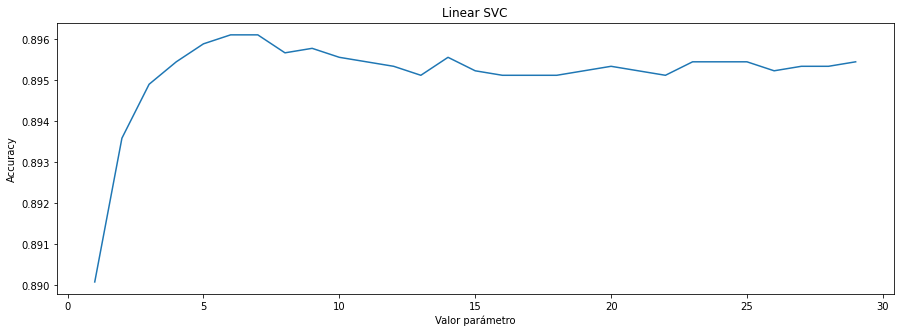

In [49]:
tune_svc(30,df_train_over,df_train_obj_over)

In [50]:
svc=LinearSVC(random_state=10,C=7,max_iter=100000)
cross_validation(svc, df_train_over,df_train_obj_over,True)

Accuracy:  0.8961095890410959


0.8961095890410959

In [51]:
svc=LinearSVC(random_state=10,C=6,max_iter=100000)
cross_validation(svc, df_train_over,df_train_obj_over,True)

Accuracy:  0.8961095890410957


0.8961095890410957

In [52]:
svc=LinearSVC(random_state=10,C=6.5,max_iter=100000)
cross_validation(svc, df_train_over,df_train_obj_over,True)

Accuracy:  0.8964383561643835


0.8964383561643835

#### Gradient Boosting

In [53]:
print("Fraction of samples to be used for fitting the individual base learners = 0.8")
gradient=GradientBoostingClassifier(random_state=10,max_features='auto',subsample=0.8)
cross_validation(gradient, df_train_over, df_train_obj_over,True)
print("Fraction of samples to be used for fitting the individual base learners = 0.6")
gradient=GradientBoostingClassifier(random_state=10,max_features='auto',subsample=0.6)
cross_validation(gradient,df_train_over, df_train_obj_over,True)
print("Fraction of samples to be used for fitting the individual base learners = 0.9")
gradient=GradientBoostingClassifier(random_state=10,max_features='auto',subsample=0.9)
cross_validation(gradient,df_train_over, df_train_obj_over,True)
print("Fraction of samples to be used for fitting the individual base learners = 0.7")
gradient=GradientBoostingClassifier(random_state=10,max_features='auto',subsample=0.7)
cross_validation(gradient,df_train_over, df_train_obj_over,True)
print("Fraction of samples to be used for fitting the individual base learners = 0.5")
gradient=GradientBoostingClassifier(random_state=10,max_features='auto',subsample=0.5)
cross_validation(gradient,df_train_over, df_train_obj_over,True)

Fraction of samples to be used for fitting the individual base learners = 0.8
Accuracy:  0.8656438356164383
Fraction of samples to be used for fitting the individual base learners = 0.6
Accuracy:  0.8658630136986302
Fraction of samples to be used for fitting the individual base learners = 0.9
Accuracy:  0.8647671232876712
Fraction of samples to be used for fitting the individual base learners = 0.7
Accuracy:  0.864986301369863
Fraction of samples to be used for fitting the individual base learners = 0.5
Accuracy:  0.8638904109589041


0.8638904109589041

Configurando el parámetro max_depth de cada estimador.

In [54]:
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier
def tune_gradient_boosting(max_value):
    acc=[]
    for i in range(2,max_value):
        gradient=GradientBoostingClassifier(max_depth=i,random_state=10,subsample=0.8)
        print(i)
        acc.append(cross_validation(gradient,df_train_over,df_train_obj_over,True))

    fig, ax =plt.subplots(figsize=(15,5))
    ax.plot(range(2,max_value), acc)
    ax.set_title('Gradient Boosting')
    ax.set_xlabel('Max depth')
    ax.set_ylabel('Accuracy')
    plt.show()

2
Accuracy:  0.8089863013698629
3
Accuracy:  0.8656438356164383
4
Accuracy:  0.8926027397260274
5
Accuracy:  0.909041095890411
6
Accuracy:  0.9174794520547944
7
Accuracy:  0.9216438356164384
8
Accuracy:  0.9219726027397261
9
Accuracy:  0.9235068493150684
10
Accuracy:  0.9221917808219178
11
Accuracy:  0.9263561643835617
12
Accuracy:  0.9255890410958905
13
Accuracy:  0.9267945205479451
14
Accuracy:  0.9274520547945206
15
Accuracy:  0.9275616438356165
16
Accuracy:  0.9283287671232877
17
Accuracy:  0.9273424657534246
18
Accuracy:  0.9277808219178082
19
Accuracy:  0.928986301369863


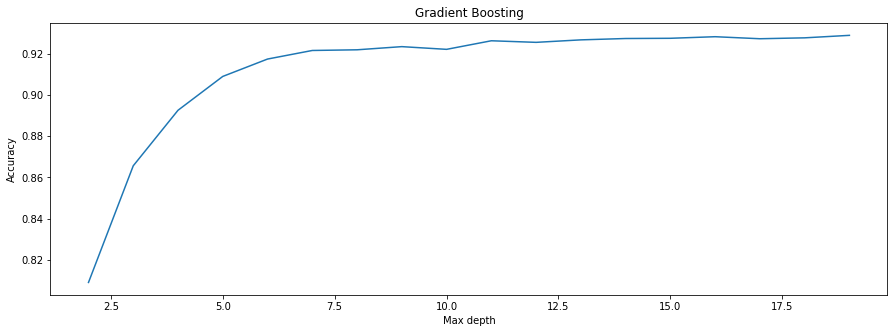

In [55]:
tune_gradient_boosting(20)

Configurando el número de estimadores.

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
def tune_gradient_boosting_2(max_value):
    acc=[]
    for i in range(50,max_value,50):
        gradient=GradientBoostingClassifier(n_estimators=i,max_depth=16,random_state=10,subsample=0.8)
        print(i)
        acc.append(cross_validation(gradient,df_train_over,df_train_obj_over,True))

    fig, ax =plt.subplots(figsize=(15,5))
    ax.plot(range(50,max_value,50), acc)
    ax.set_title('Gradient Boosting')
    ax.set_xlabel('Num estimadores')
    ax.set_ylabel('Accuracy')
    plt.show()
tune_gradient_boosting_2(500) 

50
Accuracy:  0.9254794520547944
100
Accuracy:  0.9283287671232877
150
Accuracy:  0.9311780821917808
200
Accuracy:  0.9313972602739726
250
Accuracy:  0.9313972602739726
300
Accuracy:  0.9320547945205477
350
Accuracy:  0.9318356164383561
400
Accuracy:  0.9322739726027398
450


Configurando el parámetro learning_rate.

In [ ]:
print("Learning rate=0.2")
gradient=GradientBoostingClassifier(n_estimators=400, learning_rate=0.2, random_state=10,max_features='auto',subsample=0.8,max_depth=16)
cross_validation(gradient,df_train_over,df_train_obj_over,True)
print("Learning rate=0.05")
gradient=GradientBoostingClassifier(n_estimators=400, learning_rate=0.05, random_state=10,max_features='auto',subsample=0.8,max_depth=16)
cross_validation(gradient,df_train_over,df_train_obj_over,True)
print("Learning rate=0.15")
gradient=GradientBoostingClassifier(n_estimators=400, learning_rate=0.15, random_state=10,max_features='auto',subsample=0.8,max_depth=16)
cross_validation(gradient,df_train_over,df_train_obj_over,True)
print("Learning rate=0.3")
gradient=GradientBoostingClassifier(n_estimators=400, learning_rate=0.3, random_state=10,max_features='auto',subsample=0.8,max_depth=16)
cross_validation(gradient,df_train_over,df_train_obj_over,True)
print("Learning rate=0.1")
gradient=GradientBoostingClassifier(n_estimators=400, learning_rate=0.1, random_state=10,max_features='auto',subsample=0.8,max_depth=16)
cross_validation(gradient,df_train_over,df_train_obj_over,True) 

#### Red neuronal

In [14]:
from matplotlib import pyplot as plt
from sklearn.neural_network import MLPClassifier

def tune_layers(max_value):
    acc=[]
    for i in range(20,max_value,20):
        NN=MLPClassifier(hidden_layer_sizes=(i,i),random_state=10,max_iter=1000)
        print(i)
        acc.append(cross_validation(NN,df_train_over,df_train_obj_over,True))

    fig, ax =plt.subplots(figsize=(15,5))
    ax.plot(range(20,max_value,20), acc)
    ax.set_title('Neural Network')
    ax.set_xlabel('Tamaño capas')
    ax.set_ylabel('Accuracy')
    plt.show()

20
Accuracy:  0.9414794520547944
40
Accuracy:  0.9443287671232877
60
Accuracy:  0.9425753424657535
80
Accuracy:  0.942027397260274
100
Accuracy:  0.9444383561643835
120
Accuracy:  0.9443287671232877
140
Accuracy:  0.9468493150684931
160
Accuracy:  0.9415890410958905
180
Accuracy:  0.9406027397260275
200
Accuracy:  0.9430136986301371
220
Accuracy:  0.9447671232876713
240
Accuracy:  0.9457534246575342
260
Accuracy:  0.9407123287671233
280
Accuracy:  0.9454246575342464
300
Accuracy:  0.9429041095890411
320
Accuracy:  0.9436712328767124
340
Accuracy:  0.9431232876712329
360
Accuracy:  0.9445479452054795
380
Accuracy:  0.9445479452054795
400
Accuracy:  0.9432328767123288
420
Accuracy:  0.9457534246575342
440
Accuracy:  0.9446575342465753
460
Accuracy:  0.938958904109589
480
Accuracy:  0.9448767123287671


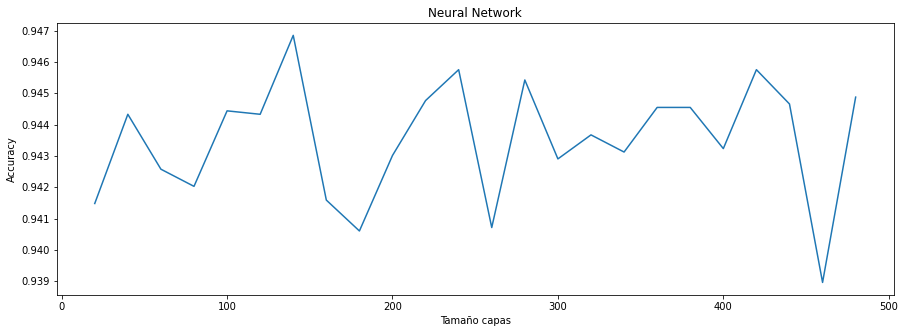

In [15]:
tune_layers(500)

In [16]:
NN=MLPClassifier(hidden_layer_sizes=(480,480),random_state=10,max_iter=10000)
cross_validation(NN,df_train_over,df_train_obj_over,True)

Accuracy:  0.9448767123287671


0.9448767123287671

In [17]:
NN=MLPClassifier(hidden_layer_sizes=(340,340),random_state=10,max_iter=10000)
cross_validation(NN,df_train_over,df_train_obj_over,True)

Accuracy:  0.9431232876712329


0.9431232876712329

In [18]:
print("Alpha=0.0015")
NN=MLPClassifier(hidden_layer_sizes=(340,340),random_state=10,max_iter=10000,alpha=0.0015)
cross_validation(NN,df_train_over,df_train_obj_over,True)
print("Alpha=0.01")
NN=MLPClassifier(hidden_layer_sizes=(340,340),random_state=10,max_iter=10000,alpha=0.01)
cross_validation(NN,df_train_over,df_train_obj_over,True)
print("Alpha=0.02")
NN=MLPClassifier(hidden_layer_sizes=(340,340),random_state=10,max_iter=10000,alpha=0.02)
cross_validation(NN,df_train_over,df_train_obj_over,True)
print("Alpha=0.05")
NN=MLPClassifier(hidden_layer_sizes=(340,340),random_state=10,max_iter=10000,alpha=0.05)
cross_validation(NN,df_train_over,df_train_obj_over,True)
print("Alpha=0.003")
NN=MLPClassifier(hidden_layer_sizes=(340,340),random_state=10,max_iter=10000,alpha=0.003)
cross_validation(NN,df_train_over,df_train_obj_over,True)
print("Alpha=0.1")
NN=MLPClassifier(hidden_layer_sizes=(340,340),random_state=10,max_iter=10000,alpha=0.1)
cross_validation(NN,df_train_over,df_train_obj_over,True)

Alpha=0.0015
Accuracy:  0.9414794520547947
Alpha=0.01
Accuracy:  0.9481643835616438
Alpha=0.02
Accuracy:  0.9471780821917809
Alpha=0.05
Accuracy:  0.9507945205479451
Alpha=0.003
Accuracy:  0.9438904109589041
Alpha=0.1
Accuracy:  0.948931506849315


0.948931506849315

### Aplicación al conjunto de test

#### Entrega 12

In [22]:
from sklearn.ensemble import ExtraTreesClassifier
extra=ExtraTreesClassifier(n_estimators=275,random_state=10)
cross_validation(extra, df_train_over, df_train_obj_over,True)
extra.fit(df_train_over,df_train_obj_over)
pred=extra.predict(df_test_num)
ids=df_test_orig["id"]

df_result = pd.DataFrame({'id': ids, 'Precio_cat': pred})
df_result.to_csv("resultados_12.csv", index=False)

Accuracy:  0.9410410958904109


#### Entrega 21

In [23]:
NN=MLPClassifier(hidden_layer_sizes=(340,340),random_state=10,max_iter=10000,alpha=0.05)
cross_validation(NN,df_train_over,df_train_obj_over,True)
NN.fit(df_train_over,df_train_obj_over)
pred=NN.predict(df_test_num)
ids=df_test_orig["id"]

df_result = pd.DataFrame({'id': ids, 'Precio_cat': pred})
df_result.to_csv("resultados_21.csv", index=False)

Accuracy:  0.9507945205479451


#### Entrega 22

In [24]:
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier
gradient=GradientBoostingClassifier(n_estimators=400, learning_rate=0.1, random_state=10,max_features='auto',subsample=0.8,max_depth=16)
cross_validation(gradient,df_train_over,df_train_obj_over,True)
gradient.fit(df_train_over,df_train_obj_over)
pred=gradient.predict(df_test_num)
ids=df_test_orig["id"]

df_result = pd.DataFrame({'id': ids, 'Precio_cat': pred})
df_result.to_csv("resultados_22.csv", index=False)

Accuracy:  0.9322739726027398
